# San Francisco Traffic Accident Frequency
## Miguel Candido Aurora Peralta
### Transformative AI for Residential and Transportation Safety Vertically Integrated Project
### Spring 2024 Senior Capstone Project <br><br>

# Imports

In [1]:
from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import json
import requests

import folium

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import LSTM, Dense, Input, concatenate, Reshape, Flatten

# Getting data
## Traffic Accident Data
Data obtained from  SFGov's dataset titled "Traffic Crashes Resulting in Injury" from 1/1/2005 to 12/31/2023.

About the data, including column descriptions: https://data.sfgov.org/Public-Safety/Traffic-Crashes-Resulting-in-Injury/ubvf-ztfx/about_data

In [2]:
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
df=pd.read_csv('gdrive/My Drive/crashes.csv')

<ipython-input-3-01903bcfc559>:1: DtypeWarning: Columns (3,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('gdrive/My Drive/crashes.csv')


## Weather

In [4]:
# Retrieving daily data for max temp, min temp, average temp, and precipitation
def get_weather_data():

  # Generate the range of dates
  start_date = datetime(2005, 4, 1)
  end_date = datetime(2023, 9, 30)
  one_day = timedelta(days=1)
  date_range = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

  # Initialize DataFrame
  weather_df = pd.DataFrame(index=date_range)

  # Codes for max temp, min temp, average temp, and precipitation
  elements = {'max_temp':'1', 'min_temp':'2', 'avg_temp':'43', 'precip':'4'}

  for key, val in elements.items():
    # RCIS API call
    url = "http://data.rcc-acis.org/"
    input_dict = {
        "sid":"USW00023272 6",
        "sdate":"2005-04-01",
        "edate":"2023-09-30",
        "elems":val,
        "output":"json"}
    params = {'params': json.dumps(input_dict)}
    headers = {'Accept': 'application/json'}
    req = requests.post('http://data.rcc-acis.org/StnData', data=params, headers=headers)
    response = req.json()
    response_data = [item[1] for item in response['data']]

    # Store in dataframe
    weather_df[key] = response_data

  return weather_df

In [7]:
raw_weather_df = get_weather_data()
# Replace "M" with NaN
raw_weather_df.replace("M", np.nan, inplace=True)

# Convert to numeric
raw_weather_df = raw_weather_df.apply(pd.to_numeric, errors='ignore')

# Impute with the median for each column
raw_weather_df.fillna(raw_weather_df.median(), inplace=True)

print(raw_weather_df.head())

            max_temp  min_temp  avg_temp  precip
2005-04-01      69.0      51.0      60.0    0.00
2005-04-02      60.0      50.0      55.0    0.00
2005-04-03      59.0      46.0      52.5    0.61
2005-04-04      60.0      46.0      53.0    0.01
2005-04-05      72.0      47.0      59.5    0.00


# Removing unnecessary data and checking datatypes

In [13]:
# Selecting necessary columns
df = df[["collision_datetime", "collision_date", "accident_year", "month", "day_of_week", 'tb_latitude', 'tb_longitude']]

In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58262 entries, 0 to 58261
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   collision_datetime  58262 non-null  object 
 1   collision_date      58262 non-null  object 
 2   accident_year       58262 non-null  int64  
 3   month               58262 non-null  object 
 4   day_of_week         58254 non-null  object 
 5   tb_latitude         58064 non-null  float64
 6   tb_longitude        58064 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 3.1+ MB
None


In [15]:
df.head()

,collision_datetime,collision_date,accident_year,month,day_of_week,tb_latitude,tb_longitude
0,12/18/2023 02:15:00 PM,2023 December 18,2023,December,Monday,37.743586,-122.463710
1,01/20/2015 10:07:00 AM,2015 January 20,2015,January,Tuesday,37.781750,-122.396380
2,04/23/2013 11:26:00 AM,2013 April 23,2013,April,Tuesday,37.761830,-122.503878
3,08/22/2007 10:30:00 PM,2007 August 22,2007,August,Wednesday,37.783992,-122.408066
4,09/03/2009 01:35:00 PM,2009 September 03,2009,September,Thursday,37.785291,-122.424770


In [16]:
df["collision_datetime"]

0        12/18/2023 02:15:00 PM
1        01/20/2015 10:07:00 AM
2        04/23/2013 11:26:00 AM
3        08/22/2007 10:30:00 PM
4        09/03/2009 01:35:00 PM
                  ...          
58257    07/12/2012 11:48:00 AM
58258    06/10/2023 11:03:00 PM
58259    10/19/2021 08:25:00 PM
58260    01/09/2012 08:25:00 AM
58261    04/05/2023 07:41:00 AM
Name: collision_datetime, Length: 58262, dtype: object

In [17]:
# Casting accident year to int
df['accident_year'] = df['accident_year'].astype(int)

# Casting datetime to datetime object
df['collision_datetime'] = pd.to_datetime(df["collision_datetime"],
                                          format="%m/%d/%Y %I:%M:%S %p")
df['collision_date'] = pd.to_datetime(df["collision_datetime"],
                                      format="%Y-%m-%d")

# Casting month and day of week to numeric format
df['month'] = pd.to_datetime(df['month'], format='%B').dt.month
df['day_of_week'] = pd.to_datetime(df['day_of_week'], format='%A').dt.dayofweek

# Renaming latitude and longitude columns for convenience
df = df.rename(columns={'tb_latitude':'latitude', 'tb_longitude':'longitude'})

I will not be training the model on post-2020 data so that irregular traffic patterns caused by lockdowns in 2020 and 2021 will not affect the overall model.

accident_year  month
2005           1        245
               2        224
               3        281
               4        268
               5        299
                       ... 
2023           8        262
               9        271
               10       293
               11       245
               12       266
Length: 228, dtype: int64


<Axes: xlabel='accident_year,month'>

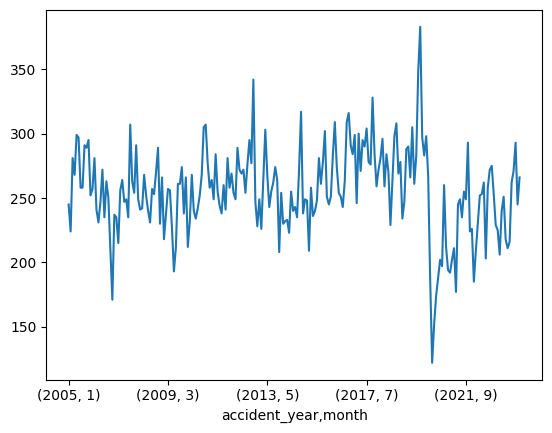

In [18]:
# Graph of accident counts by month over time
yearly_counts = df.groupby(by=['accident_year', 'month']).size()
print(yearly_counts)
yearly_counts.plot(kind='line')

In [19]:
# Subsetting data
selected_dates = df[df['accident_year'] < 2015].sort_values(by='collision_datetime')

# Creating map of area where accidents in dataset are occurring

In [20]:
mean_lat = selected_dates['latitude'].mean()
mean_long = selected_dates['longitude'].mean()

In [21]:
min_lat = selected_dates['latitude'].min()-.01
max_lat = selected_dates['latitude'].max()+.01
print(f"Minimum latitude: {min_lat}")
print(f"Maximum latitude: {max_lat}")


Minimum latitude: 37.69808572900908
Maximum latitude: 37.83986189124343


In [22]:
min_long = selected_dates['longitude'].min()-.01
max_long = selected_dates['longitude'].max()+.01
print(f"Minimum longitude: {min_long}")
print(f"Maximum longitude: {max_long}")



Minimum longitude: -122.52361620862789
Maximum longitude: -122.3483278940174


All possible latitude and longitude values within the city limits should fit in this area. I'll encode the accidents by assigning them to a cell in a square matrix that covers this area.

In [23]:
m = folium.Map(location=(mean_lat, mean_long),
               zoom_start=12,
               tiles='OpenStreetMap')

folium.Marker(
    location = [min_lat, min_long]
).add_to(m)
folium.Marker(
    location = [max_lat, max_long]
).add_to(m)
folium.Marker(
    location = [max_lat, min_long]
).add_to(m)
folium.Marker(
    location = [min_lat, max_long]
).add_to(m)
m

In [24]:
import numpy as np

# Generate 31 equally spaced points within the latitude and longitude ranges (30x30 grid)
lat_values = np.linspace(min_lat, max_lat, 31)
long_values = np.linspace(min_long, max_long, 31)

# Center map
mean_lat = np.mean(lat_values)
mean_long = np.mean(long_values)
m_grid = folium.Map(location=(mean_lat, mean_long), zoom_start=12)

# Horizontal grid lines
for lat in lat_values:
    polyline = [(lat, min_long), (lat, max_long)]
    folium.PolyLine(locations=polyline, color='blue', weight = 0.5).add_to(m_grid)

# Vertical grid lines
for long in long_values:
    polyline = [(min_lat, long), (max_lat, long)]
    folium.PolyLine(locations=polyline, color='blue', weight = 0.5).add_to(m_grid)

m_grid

In [25]:
grid_boundaries = []

# Iterate through latitude values
for i in range(len(lat_values) - 1):
    lat1, lat2 = lat_values[i], lat_values[i + 1]
    # Iterate through longitude values
    for j in range(len(long_values) - 1):
        long1, long2 = long_values[j], long_values[j + 1]
        # Define the boundaries of the grid area
        boundary = [(lat1, long1), (lat1, long2), (lat2, long2), (lat2, long1), (lat1, long1)]
        # Append the boundary to the list
        grid_boundaries.append(boundary)

# Preparing data for input

In [26]:
selected_dates.dropna(subset = ['latitude', 'longitude', "month", "day_of_week"], inplace=True)

## Creating 30x30 matrices with the accident data assigned to its respective cell in the grid

In [51]:
# Create a dictionary to store the matrices for each date
date_matrices = {}

# Group the dataframe by 'collision_date'
grouped_dates = selected_dates.groupby('collision_date')

# Iterate through each date group
for date, group in grouped_dates:
    # Create a 30x30 matrix initialized with zeros
    matrix = np.zeros((30, 30), dtype=int)

    # Iterate through each row in the group
    for index, row in group.iterrows():
        # Compute the indices for the matrix
        lat_index = int((row['latitude'] - min_lat) / (max_lat - min_lat) * 30)-1
        long_index = int((row['longitude'] - min_long) / (max_long - min_long) * 30)-1

        # Increment the corresponding cell in the matrix
        matrix[lat_index, long_index] += 1

    # Store the matrix in the dictionary with the date as the key
    dt_object = date.strftime('%Y-%m-%d')
    date_matrices[dt_object] = matrix

In [28]:
# Check if daily accident sums are equal
daily_count = grouped_dates.size().to_list()
matrices_sum = []
for key in date_matrices.keys():
  matrices_sum.append(sum(sum(date_matrices[key])))
daily_count == matrices_sum

True

# Make input suitable for LSTM

In [29]:
# Prepare input matrices
dates = list(date_matrices.keys())
matrices = [date_matrices[date] for date in dates]
input_matrices = np.array(matrices)

# Prepare target matrices
# Shift the matrices by one time step for sequence prediction
target_matrices = np.roll(input_matrices, -1, axis=0)

In [30]:
# Extract day of week and month
days_of_week = selected_dates['day_of_week']
months = selected_dates['month']

# Convert the list of days_of_week and months to np arrays
days_of_week_array = np.array(days_of_week)
months_array = np.array(months)

# Reshape the arrays to be column vectors
days_of_week_array = days_of_week_array.reshape(-1, 1)
months_array = months_array.reshape(-1, 1)

# Create OneHotEncoder instances for day of the week and month separately
encoder_day_of_week = OneHotEncoder(categories='auto', sparse_output=False)
encoder_month = OneHotEncoder(categories='auto', sparse_output=False)

# Fit and transform the data for day of the week
encoded_days_of_week = encoder_day_of_week.fit_transform(days_of_week_array)

# Fit and transform the data for month
encoded_months = encoder_month.fit_transform(months_array)

Index(['2005-01-01', '2005-01-01', '2005-01-01', '2005-01-01', '2005-01-01',
       '2005-01-01', '2005-01-02', '2005-01-02', '2005-01-02', '2005-01-02',
       ...
       '2014-12-30', '2014-12-30', '2014-12-30', '2014-12-31', '2014-12-31',
       '2014-12-31', '2014-12-31', '2014-12-31', '2014-12-31', '2014-12-31'],
      dtype='object', length=30373)

In [60]:
raw_weather_df

,max_temp,min_temp,avg_temp,precip
2005-04-01,69.0,51.0,60.0,0.00
2005-04-02,60.0,50.0,55.0,0.00
2005-04-03,59.0,46.0,52.5,0.61
2005-04-04,60.0,46.0,53.0,0.01
2005-04-05,72.0,47.0,59.5,0.00
...,...,...,...,...
2023-09-26,70.0,60.0,65.0,0.07
2023-09-27,71.0,57.0,64.0,0.00
2023-09-28,71.0,56.0,63.5,0.00
2023-09-29,65.0,57.0,61.0,0.00


In [62]:
# Get weather data
weather_df = pd.DataFrame(raw_weather_df[pd.to_datetime(dates).strftime('%Y-%m-%d'), :])
temp_precip_data = raw_weather_df[['max_temp', 'min_temp', 'avg_temp', 'precip']].values

# Normalization
scaler = MinMaxScaler()
temp_precip_data_normalized = scaler.fit_transform(temp_precip_data)

# Reshape temperature and precipitation data to match model input shape
temp_precip_data_reshaped = temp_precip_data_normalized.reshape(-1, 1, 4)

InvalidIndexError: (Index(['2005-01-01', '2005-01-01', '2005-01-01', '2005-01-01', '2005-01-01',
       '2005-01-01', '2005-01-02', '2005-01-02', '2005-01-02', '2005-01-02',
       ...
       '2014-12-30', '2014-12-30', '2014-12-30', '2014-12-31', '2014-12-31',
       '2014-12-31', '2014-12-31', '2014-12-31', '2014-12-31', '2014-12-31'],
      dtype='object', length=30373), slice(None, None, None))

# Train validation test split

In [97]:
# For the model without weather
X_train_no_weather, X_test_no_weather, y_train_no_weather, y_test_no_weather = train_test_split(input_matrices,
                                                                                                target_matrices,
                                                                                                test_size=0.2,
                                                                                                random_state=42)

# For the model with weather
X_train_weather_data = [input_matrices, days_of_week_array, months_array, temp_precip_data_reshaped]
X_train_weather, X_test_weather, y_train_weather, y_test_weather = train_test_split(X_train_weather_data,
                                                                                    target_matrices,
                                                                                    test_size=0.2,
                                                                                    random_state=42)


ValueError: Found input variables with inconsistent numbers of samples: [4, 30373]

In [98]:
print("Shape of input_matrices:", input_matrices.shape)
print("Shape of days_of_week_array:", days_of_week_array.shape)
print("Shape of months_array:", months_array.shape)
print("Shape of temp_precip_data_reshaped:", temp_precip_data_reshaped.shape)
print("Shape of target_matrices:", target_matrices.shape)

Shape of input_matrices: (30373, 30, 30)
Shape of days_of_week_array: (30600, 1)
Shape of months_array: (30600, 1)
Shape of temp_precip_data_reshaped: (6757, 1, 4)
Shape of target_matrices: (30373, 30, 30)


# Define models
Defining two models, one that includes the weather data and one that does not. I will compare the performance of the two.

## Without weather data

In [ ]:
# Input shapes
input_shape_matrices = (30, 30)
input_shape_day_of_week = (7,)
input_shape_month = (12,)

# Define input layers
input_matrices_layer = Input(shape=input_shape_matrices,
                             name="input_matrices")
input_day_of_week = Input(shape=input_shape_day_of_week,
                          name="input_day_of_week")
input_month = Input(shape=input_shape_month,
                    name="input_month")

# Concatenate the day of week and month inputs
concatenated_inputs = concatenate([input_day_of_week, input_month],
                                  name="concatenate_dow_and_month")

# Reshape concatenated input to include the timestep dimension
reshaped_inputs = Reshape((1, -1),
                          name="reshape_concat")(concatenated_inputs)

# Define LSTM layer for processing the concatenated input
lstm = LSTM(units=64,
            name="lstm")(reshaped_inputs)

# Flatten the matrix input
flattened_matrices = Flatten(name="flatten_matrices")(input_matrices_layer)

# Concatenate LSTM output with the flattened matrix input
concatenated_outputs = concatenate([lstm, flattened_matrices],
                                   name = 'concatenate_lstm_with_matrix')

# Define output layer
output = Dense(units=30*30,
               activation='linear',
               name="dense_output")(concatenated_outputs)  # Output is a matrix

# Reshape output to match the shape of the input matrix
output = Reshape((30, 30),
                 name="reshape_output_match_input")(output)

# Define the model
model = Model(inputs=[input_matrices_layer, input_day_of_week, input_month],
              outputs=output,
              name="no_weather")

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model summary
model.summary()


In [ ]:
# Fit model
history_no_weather = model.fit(
    [X_train, encoded_days_of_week[:len(X_train)], encoded_months[:len(X_train)]],
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=([X_val, encoded_days_of_week[len(X_train):len(X_train)+len(X_val)], encoded_months[len(X_train):len(X_train)+len(X_val)]], y_val)
)

## Model including weather

In [ ]:
input_shape_weather = (4,)

# Define weather input layer
input_weather = Input(shape=input_shape_weather,
                      name='input_weather')

# Concatenate the day of week, month, and temp/precip inputs
concatenated_inputs_weather = concatenate([input_day_of_week, input_month, input_weather],
                                          name="concatenated_dow_month_weather")

# Reshape concatenated input to include the timestep dimension
reshaped_inputs_weather = Reshape((1, -1),
                                  name='reshape_concat_input_weather')(concatenated_inputs_weather)

# Define LSTM layer for processing the concatenated input
lstm_out_weather = LSTM(units=64,
                        name='lstm_weather')(reshaped_inputs_weather)

# Flatten the matrix input
flattened_matrices_weather = Flatten(name = 'flatten_matrices_weather')(input_matrices_layer)

# Concatenate LSTM output with the flattened matrix input
concatenated_outputs_weather = concatenate([lstm_out_weather, flattened_matrices_weather],
                                           name = 'concat_lstm_out_matrix_weather')

# Define output layer
output_weather = Dense(units=30*30, activation='linear',
                       name = 'weather_out')(concatenated_outputs_weather)  # Output is a matrix

# Reshape output to match the shape of the input matrix
output = Reshape((30, 30),
                 name='reshape_out_weather')(output)

# Define the model
model_weather = Model(inputs=[input_matrices_layer,
                              input_day_of_week,
                              input_month,
                              input_weather],
                      outputs=output,
                      name = 'model_weather')

# Compile the model
model_weather.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model summary
model_weather.summary()

In [ ]:
predictions = model.predict([X_test, encoded_days_of_week[len(X_train) + len(X_val):], encoded_months[len(X_train) + len(X_val):]])

In [ ]:
pred_sum = np.sum(predictions, axis=0)
actual_sum = np.sum(y_test, axis=0)
train_sum = np.sum(input_matrices, axis=0)
plt.subplot(1, 3, 1)
plt.imshow(pred_sum)

plt.subplot(1, 3, 2)
plt.imshow(actual_sum)

plt.subplot(1, 3, 3)
plt.imshow(train_sum)

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
mae

# Evaluating performance of the model
Problem: How to evaluate the performance of a neural network that outputs a 30x30 matrix?
MSE and MAE are only considering the values in the matrix, not the location of the values.

## Potential approach:
- Comparing monthly estimates to actual monthly outcomes.
- Sum all of the matrices for predicted month and actual month.
- Convert summed matrices to 30x30 image.
- Calculate the structural similarity index between the actual and predicted images.

In [ ]:
import numpy as np

In [ ]:
m1 = input_matrices[0]
m2 = input_matrices[20]
m3 = input_matrices[0]
for i in input_matrices[1:31]:
  m3 += i

In [ ]:
print("m1")
print(m1)
print("\nm2")
print(m2)
print()
print(m3)

In [ ]:
from skimage.metrics import structural_similarity as ssim

def compare_matrices_ssim(matrix1, matrix2):
    """
    Compare the similarity between two matrices using Structural Similarity Index (SSIM).

    Parameters:
        matrix1 (numpy.ndarray): First matrix.
        matrix2 (numpy.ndarray): Second matrix.

    Returns:
        float: Structural Similarity Index (SSIM) between the two matrices.
    """
    return ssim(matrix1, matrix2)

ssim_value = compare_matrices_ssim(m1, m2)
ssim_value

In [ ]:
import skimage
skimage.data.camera()
import numpy as np
from matplotlib import pyplot as plt


plt.subplot(1, 2, 1)
plt.imshow(m1)
plt.subplot(1, 2, 2)
plt.imshow(m3)
plt.title('Matrix 2')



In [ ]:
from folium import plugins

# Define the boundaries of the image overlay
overlay_bounds = [(min_lat, min_long), (max_lat, max_long)]

# Create the Folium map
m = folium.Map(location=(mean_lat, mean_long), zoom_start=12)

# Add the image overlay to the map
folium.raster_layers.ImageOverlay(
    image=np.array(m3),  # Convert m1 to numpy array
    bounds=overlay_bounds,
    opacity=0.5,
).add_to(m)
m

In [ ]:
! pip install folium[plugins]
